In [ ]:
# default_exp subcoco_lightning_utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Pytorch Lightning Specific Utilities

Extracted common utilities for all Pytorch Lightning related data loading stuff

In [ ]:
#export
import cv2, json, os, requests, sys, tarfile
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pickle
import random

import albumentations as A
import pytorch_lightning as pl
import torch, torchvision
import torch.nn.functional as F
import torch.multiprocessing

from collections import defaultdict
from functools import reduce
from gpumonitor.monitor import GPUStatMonitor
from gpumonitor.callbacks.lightning import PyTorchGpuMonitorCallback
from IPython.utils import io
from pathlib import Path
from PIL import Image
from PIL import ImageStat

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.core.step_result import TrainResult

from tqdm import tqdm
from typing import Hashable, List, Tuple, Union, Iterable

from torch import nn
from torch.nn import Module
from torch import optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms

from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningDataModule, LightningModule
from mcbbox.subcoco_utils import *

print(f"Python ver {sys.version}, torch {torch.__version__}, torchvision {torchvision.__version__}, pytorch_lightning {pl.__version__}, Albumentation {A.__version__}")

Python ver 3.8.5 (default, Jul 28 2020, 12:59:40) 
[GCC 9.3.0], torch 1.7.0, torchvision 0.8.1, pytorch_lightning 1.0.4, Albumentation 0.5.0


In [ ]:
#hide
img_sz, bs, acc, workers, head_runs, full_runs = 128, 4, 8, 1, 1, 1
datadir, url, img_subdir = '/tmp', 'http://files.fast.ai/data/examples/coco_tiny.tgz', 'train'
stem = Path(url).stem
img_dir=f'{datadir}/{stem}/{img_subdir}'
train_json = fetch_subcoco(datadir=datadir, url=url, img_subdir=img_subdir)
stats = load_stats(train_json, img_dir=img_dir, force_reload=False)

/home/brian/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Wrap Data Loading Logic using Pytorch-Lightning

In order to use Pytorch Lightning to load data, we need to define a DataModule to encapsulate all the data loading logic. At first I thought I can reuse CocoDetect() from torchvision but it uses cocoapi downstream and expects json annotation file to be of this [format](https://cocodataset.org/#format-data):
```
annotation{
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height],
    "iscrowd": 0 or 1,
}
```

Tiny and Sample Coco's train.json file only has a subset of the above fields:
```
“Annotations”: [
    {
      "image_id": 542959,
      "bbox": [
        32.52,
        86.34,
        8.53,
        9.41
      ],
      "category_id": 62
    },
    ...
]
``` 

Thus we will need to make a Dataset to handle it properly.

In [ ]:
# export
class SubCocoDataset(torchvision.datasets.VisionDataset):
    """
    Simulate what torchvision.CocoDetect() returns for target given fastai's coco subsets
    Args:
        root (string): Root directory where images are downloaded to.
        stats (CocoDatasetStats):
    """

    def __init__(self, root:str, stats:CocoDatasetStats, img_ids:list=[], 
                 bbox_aware_tfms:callable=None, safe_box_margin:float=0.0, safe_box_size:float=0.0):
        super(SubCocoDataset, self).__init__(root) 
        self.stats = stats
        self.img_ids = []
        n_missing = 0
        for img_id in img_ids:
            img_fname = stats.img2fname[img_id]
            if not os.path.isfile(stats.img_dir/img_fname):
                n_missing += 1
            elif stats.img2sz.get(img_id, None) is None:
                n_missing += 1
            elif safe_box_size <= 0.0 and safe_box_margin <= 0.0:
                self.img_ids.append(img_id)
            else:
                img_w, img_h = stats.img2sz[img_id]
                l2bs = stats.img2l2bs[img_id]
                safe_l2bs = {}
                for l, bs in l2bs.items():
                    safe_bs = []
                    for bx, by, bw, bh in bs:
                        if box_within_bounds(bx, by, bw, bh, img_w, img_h, safe_box_margin, safe_box_size):
                            safe_bs.append((bx, by, bw, bh))
                    if len(safe_bs) > 0:
                        safe_l2bs[l] = safe_bs
                if len(safe_l2bs) <= 0:
                    n_missing += 1
                else:
                    stats.img2l2bs[img_id] = safe_l2bs
                    self.img_ids.append(img_id)
                    
        if n_missing > 0 : print(f'Warning: {n_missing} out of {len(img_ids)} image files are missing or have unsafe boxes!!!')
        self.bbox_aware_tfms = bbox_aware_tfms

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        img_id = self.img_ids[index] if index < len(self.img_ids) else 0
        img_fname = self.stats.img2fname.get(img_id, None)
        if img_id is None or img_fname ==None:
            return (None, None)
        img_fpath = os.path.join(self.root, img_fname)
        img_w, img_h = self.stats.img2sz.get(img_id, (1,1))
        target = { 'boxes': [], 'labels': [], 'image_id': img_id, 'width': img_h, 'height': img_h, 'areas': [], 'iscrowds': 0, 'ids': [] }
        count = 0
        lbs = self.stats.img2lbs.get(img_id,[])
        for l, x, y, w, h in lbs:
            count += 1
            target['boxes'].append([x, y, x+w, y+h]) # FRCNN and RetNet wants x1,y1,x2,y2 format!
            target['labels'].append(l)
            target['areas'].append(w*h)
            anno_id = img_id*1000 + count
            target['ids'].append(anno_id)

        img = cv2.imread(img_fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.bbox_aware_tfms is not None:
            transformed = self.bbox_aware_tfms(image=img, bboxes=target['boxes'], class_labels=target['labels'])
            img = transformed['image']
            target['boxes'] = transformed['bboxes']
            target['labels'] = transformed['class_labels']

        for k, v in target.items():
            target[k] = torch.tensor(v, dtype=(torch.float if k in ['boxes', 'width', 'height', 'areas'] else torch.long))
        
        img = torch.from_numpy(img/255.0).float().permute(2, 0, 1)
        return img, target

    def __len__(self):
        return len(self.img_ids)

Test w/o Augmentations

img =
tensor([[[0.9765, 0.9451, 0.9373,  ..., 0.9373, 0.9647, 0.8980],
         [0.9451, 0.9373, 0.9098,  ..., 0.9216, 0.9255, 0.9255],
         [0.9098, 0.9725, 0.9373,  ..., 0.9412, 0.9294, 0.9333],
         ...,
         [0.8902, 0.9608, 0.9255,  ..., 0.9333, 0.9647, 0.8980],
         [0.9216, 0.9216, 0.9020,  ..., 0.8941, 0.9176, 0.9255],
         [0.9569, 0.9294, 0.9294,  ..., 0.9059, 0.9176, 0.9569]],

        [[0.9647, 0.9333, 0.9373,  ..., 0.9529, 0.9804, 0.9137],
         [0.9333, 0.9255, 0.9098,  ..., 0.9373, 0.9412, 0.9412],
         [0.9098, 0.9725, 0.9373,  ..., 0.9569, 0.9451, 0.9569],
         ...,
         [0.8627, 0.9333, 0.8980,  ..., 0.9098, 0.9412, 0.8745],
         [0.8902, 0.8902, 0.8784,  ..., 0.8706, 0.8863, 0.8980],
         [0.9255, 0.8980, 0.9059,  ..., 0.8824, 0.8902, 0.9294]],

        [[0.9294, 0.8980, 0.8902,  ..., 0.8980, 0.9216, 0.8549],
         [0.8980, 0.8902, 0.8627,  ..., 0.8824, 0.8824, 0.8824],
         [0.8627, 0.9255, 0.8902,  ..., 0.9020, 0.89

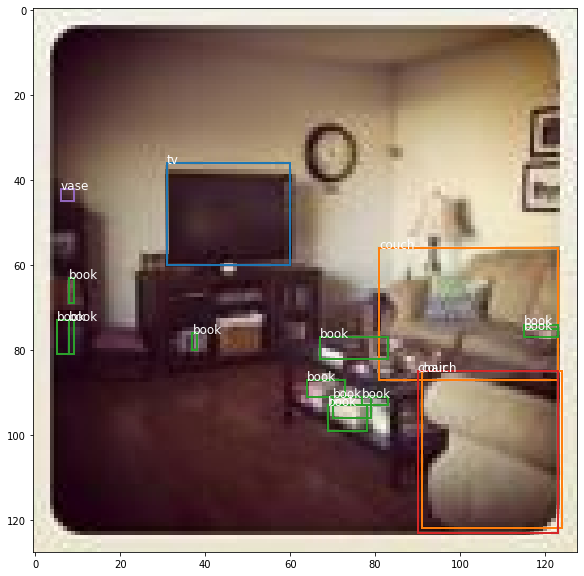

In [ ]:
#hide
best_img_pos = 89
dataset = SubCocoDataset(img_dir, stats, img_ids=list(stats.img2sz.keys()))
img,tgt = dataset[best_img_pos]
print(f"img =\n{img}\ntgt =\n{tgt}")
tgt_l2bs = defaultdict(empty_list)
n_boxs = 0
for l, b in zip(list(tgt['labels']), tgt['boxes']):
    n_boxs +=1
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

print(f"n_boxs = {n_boxs}")
pimg = torchvision.transforms.ToPILImage()(img)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)
pre_img = img

## Custom Transforms

Albumentations Normalize() seems to produce distortion, need a transform to clamp the min max pixel value btw (0, 1)

In [ ]:
#export
class NormClamp(A.ImageOnlyTransform):
    def __init__(self, mean=(.5, .5, .5), std=(.25, .25, .25), always_apply=True, p=1.0):
        super(NormClamp, self).__init__(always_apply, p)
        self.mean = mean
        self.std = std
        
    def apply(self, image, **params):
        image = .333*(image - self.mean)/(self.std)
        image = np.clip(image, 0, 255)
        return image
    
    def get_transform_init_args_names(self):
        return ("mean", "std")
    
class ClampPixel(A.ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1.0):
        super(ClampPixel, self).__init__(always_apply, p)
        
    def apply(self, image, **params):
        image = np.clip(image, 0, 255)
        return image
    
    def get_params(self): return {}
    def get_transform_init_args_names(self): return ()

Verify the image transformation works using Albumentation, especially random transform to both image and target.

mean = [0.49525855 0.42753974 0.39455189], std = [0.25728409 0.2552822  0.23711022]
n_boxs = 16


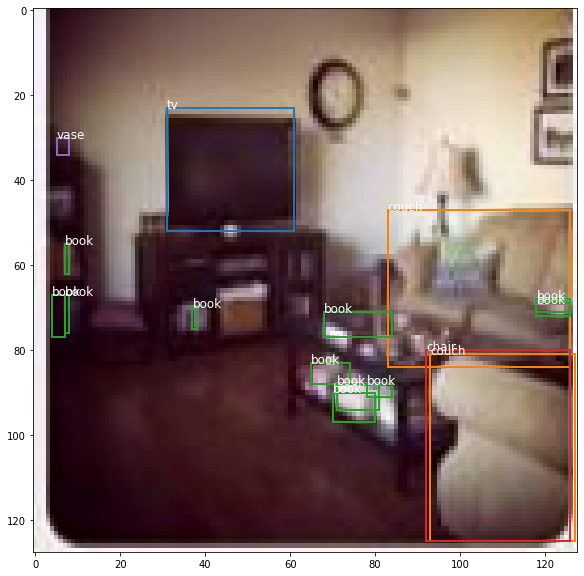

In [ ]:
#hide
print(f"mean = {stats.chn_means/255}, std = {stats.chn_stds/255}")
tfms = A.Compose([
    A.ShiftScaleRotate(shift_limit=.025, scale_limit=0.025, rotate_limit=9),
    A.RandomSizedBBoxSafeCrop(width=128,height=128),
    A.HorizontalFlip(p=0.5), 
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.Blur(blur_limit=(1, 3)),
    A.Normalize(mean=stats.chn_means/255, std = stats.chn_stds/255, max_pixel_value=3), #why is this fucked up? why max px val 3
    ClampPixel()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

dataset = SubCocoDataset(img_dir, stats, img_ids=list(stats.img2sz.keys()), bbox_aware_tfms=tfms) 
img, tgt = dataset[best_img_pos]
tgt_l2bs = defaultdict(empty_list)
n_boxs = 0
for l, b in zip(list(tgt['labels']), tgt['boxes']):
    n_boxs +=1
    tgt_l2bs[int(l)].append( (int(b[0]), int(b[1]), int(b[2]-b[0]), int(b[3]-b[1])) ) 

print(f"n_boxs = {n_boxs}")
pimg = torchvision.transforms.ToPILImage()(img)
overlay_img_bbox(pimg, tgt_l2bs, stats.lbl2name)

## Custom DataModule

In [ ]:
#export
class SubCocoDataModule(LightningDataModule):

    def __init__(self, root, stats, bs=32, workers=4, split_ratio=0.9, shuffle=True, 
                 train_transforms=None, val_transforms=None):
        super().__init__(train_transforms=train_transforms, val_transforms=val_transforms)
        self.dir = root
        self.bs = bs
        self.workers = workers
        self.stats = stats
        self.split_ratio = split_ratio
        self.shuffle = shuffle

        num_items = stats.num_imgs
        num_train = int(self.split_ratio*num_items)
        img_ids = list(stats.img2sz.keys())
        if shuffle: random.shuffle(img_ids)
            
        train_img_ids = img_ids[:num_train]
        val_img_ids = img_ids[num_train:]
        
        self.train = SubCocoDataset(self.dir, self.stats, img_ids=train_img_ids, bbox_aware_tfms=train_transforms) 
        self.val = SubCocoDataset(self.dir, self.stats, img_ids=val_img_ids, bbox_aware_tfms=val_transforms)
        
    def collate_fn(self, batch):
        return tuple(zip(*batch))

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn, shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.bs, num_workers=self.workers, collate_fn=self.collate_fn, shuffle=False)

In [ ]:
#hide
tiny_coco_dm = SubCocoDataModule(img_dir, stats, bs=2, train_transforms=tfms, val_transforms=tfms)
tdl=tiny_coco_dm.train_dataloader()
images, targets = next(iter(tdl))

len(images), len(targets), images[0], targets[0]

(2,
 2,
 tensor([[[0.7647, 0.7647, 0.7647,  ..., 0.6529, 0.7088, 0.7393],
          [0.7596, 0.7596, 0.7596,  ..., 0.6580, 0.7139, 0.7393],
          [0.7546, 0.7546, 0.7596,  ..., 0.6682, 0.7190, 0.7444],
          ...,
          [0.6377, 0.6428, 0.6529,  ..., 0.2058, 0.2058, 0.2058],
          [0.6072, 0.6123, 0.6225,  ..., 0.2008, 0.2008, 0.2008],
          [0.5869, 0.5971, 0.6072,  ..., 0.1957, 0.1957, 0.1957]],
 
         [[0.7206, 0.7206, 0.7257,  ..., 0.6079, 0.6489, 0.6745],
          [0.7154, 0.7206, 0.7206,  ..., 0.6130, 0.6540, 0.6745],
          [0.7052, 0.7154, 0.7206,  ..., 0.6233, 0.6591, 0.6796],
          ...,
          [0.5721, 0.5772, 0.5874,  ..., 0.1573, 0.1573, 0.1573],
          [0.5413, 0.5465, 0.5618,  ..., 0.1573, 0.1573, 0.1573],
          [0.5209, 0.5311, 0.5413,  ..., 0.1624, 0.1624, 0.1624]],
 
         [[0.7047, 0.6991, 0.6936,  ..., 0.5558, 0.6054, 0.6330],
          [0.6991, 0.6991, 0.6936,  ..., 0.5613, 0.6109, 0.6330],
          [0.6936, 0.6936, 0.688

## Base Abstract Lightning Module For Reuse Across Different Neural Architecture

In [ ]:
# export
class AbstractDetectorLightningModule(LightningModule):
    
    def __init__(self, num_classes=1, img_sz=128, model_train_loss=True, bs:int=1, 
                 steps_per_epoch:int=0, lr:float=1e-2, noisy=False, calc_metrics=False, **kwargs):
        LightningModule.__init__(self)
        self.num_classes = num_classes
        self.model_train_loss = model_train_loss
        self.img_sz = img_sz
        self.lr = lr
        self.bs = bs
        self.steps_per_epoch = steps_per_epoch
        self.noisy = noisy
        self.calc_metrics = calc_metrics
        self.model = self.create_model(num_classes=num_classes, img_sz=img_sz, lr=lr, bs=bs, steps_per_epoch=steps_per_epoch, **kwargs)
    
    def create_model(self, **kwargs): raise NotImplementedError()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        if self.steps_per_epoch <= 0: return optimizer
        return {
           'optimizer': optimizer,
           'lr_scheduler': torch.optim.lr_scheduler.OneCycleLR(
               optimizer, self.lr, steps_per_epoch=self.steps_per_epoch, epochs=1,)
        }

    def set_grad(self, mod:Module, requires_grad:bool=True):
        for param in mod.parameters():
            param.requires_grad = requires_grad

    def get_main_model(self): raise NotImplementedError()
        
    def get_head(self)->Union[Iterable[Module], Module]: raise NotImplementedError()
        
    def get_backbone(self): raise NotImplementedError()
        
    def freeze_head(self):
        head = self.get_head()
        if isinstance(head, Iterable):
            for head_net in head:
                self.set_grad(head_net, requires_grad=False)
        else:
            self.set_grad(head, requires_grad=False)
            
    def unfreeze_head(self):
        head = self.get_head()
        if isinstance(head, Iterable):
            for head_net in head:
                self.set_grad(head_net, requires_grad=True)
        else:
            self.set_grad(head, requires_grad=True) 
        
    def freeze_backbone(self):
        self.set_grad(self.get_backbone(), requires_grad=False)
        
    def unfreeze_backbone(self):
        self.set_grad(self.get_backbone(), requires_grad=True)
        
    def freeze_batchnorm(self):
        for m in self.model.modules():
            if type(m) is torch.nn.BatchNorm2d: 
                self.set_grad(m, requires_grad=False)
        
    def unfreeze_batchnorm(self):
        for m in self.model.modules():
            if type(m) is torch.nn.BatchNorm2d: 
                self.set_grad(m, requires_grad=True)
    
    def fix_boxes_batch(self, xs, ys, boxs_key='boxes', cats_key='labels'):
        safe_xs, safe_ys = [], []
        for x, y in zip(xs, ys):
            n_boxs = len(y.get(boxs_key,[])) 
            n_cls = len(y.get(cats_key,[]))
            if n_boxs <= 0:
                print(f"Warning: Removing X,Y as Y has no boxes! {y}")
            elif n_boxs != n_cls:
                print(f"Warning: Removing X,Y as Y n_nboxs {n_boxs} != n_cls {n_cls}")
            else:
                bs = y['boxes'] # should be Tensor of shape bs x 4
                # clamping min max value of x1,x2,y1,y2
                for bi in range(len(bs)):
                    bs[bi, 0] = clamp_fn(0, self.img_sz-2)(bs[bi, 0].item())
                    bs[bi, 1] = clamp_fn(0, self.img_sz-2)(bs[bi, 1].item())
                    bs[bi, 2] = clamp_fn(bs[bi, 0].item()+1, self.img_sz-1)(bs[bi, 2].item())
                    bs[bi, 3] = clamp_fn(bs[bi, 1].item()+1, self.img_sz-1)(bs[bi, 3].item())
                safe_xs.append(x)
                safe_ys.append(y)
        return safe_xs, safe_ys
        
    def metrics(self, preds, targets):
        metrics = torch.zeros((min(len(preds), len(targets)), 2))
        for i, (p,t) in enumerate(zip(preds, targets)):
            metrics[i,0] = calc_wavg_F1(p, t, .5, .5)
            metrics[i,1] = SubCocoWrapper(p, t, self.img_sz, self.img_sz).metrics()[0]
        return metrics

    def training_step(self, train_batch, batch_idx):
        if self.noisy: print('Entering training_step')
        self.model.train()
        self.model.cuda()
        xs, ys = self.fix_boxes_batch(*train_batch)
        if len(xs) <= 0: return 0
        with torch.set_grad_enabled(True):
            losses = self.model.forward(xs, ys) if self.model_train_loss else self.forward(xs, ys)
            losses = sum(losses.values())
        if self.noisy: print(f'Exiting training_step, returning {losses}')
        return losses
    
    def validation_step(self, val_batch, batch_idx):
        if self.noisy: print('Entering validation_step')
        self.model.cuda()
        # turn off auto gradient for validation step
        with torch.no_grad():
            xs, ys = val_batch
            self.model.train()
            losses = self.model.forward(xs, ys) if self.model_train_loss else self.forward(xs, ys)
            losses = sum(losses.values())
            if self.calc_metrics:
                self.model.eval()
                preds = self.forward(xs)
                metrics = self.metrics(preds, ys)
        
        result = {'val_loss': losses} 
        if self.calc_metrics:
            result['val_acc'] = metrics[:,0].mean()
            result['val_coco'] = metrics[:,1].mean()
            
        if self.noisy: print(f'Exiting validation_step, returning {result}')
        return result
    
    def validation_epoch_end(self, outputs):
        if self.noisy: print('Entering validation_epoch_end')
        
        result = {'val_loss': sum([ o['val_loss'] for o in outputs ])/len(outputs)}
        if self.calc_metrics:
            result['val_acc'] = sum([ o['val_acc'] for o in outputs ])/len(outputs)
            result['val_coco'] = sum([ o['val_coco'] for o in outputs ])/len(outputs)
            
        if self.noisy: print(f'Exiting validation_epoch_end, returning {result}')
        self.log_dict(result)

    def forward(self, imgs, *args):
        if self.noisy: print(f'Entering forward, training = {self.training}')
        # assume all models take Xs & Ys during training
        if self.training:
            preds = self.model(imgs, *args)
        else:
            # turn off auto gradient for validation step
            with torch.no_grad():
                preds = self.model(imgs)
        if self.noisy: print(f'Exiting forward, returning {preds}')
        return preds

In [ ]:
#hide
class ToyModule(AbstractDetectorLightningModule):
    def __init__(self, **kwargs):
        AbstractDetectorLightningModule.__init__(self, **kwargs)
    
    def create_model(self, num_classes=1, **kwargs): return nn.Linear(3*128*128, num_classes)
    def get_main_model(self): return self.model
    def get_head(self): return self.model
    def get_backbone(self):  return self.model
    def forward(self, imgs, *args): 
        if self.noisy: print(f'Entering forward, training = {self.training}')
        batch_size = len(imgs)
        imgs = torch.stack(imgs).view(batch_size, -1)
        res = self.model(imgs)
        if self.training:
            res = F.mse_loss(res, torch.zeros_like(res))
        if self.noisy: print(f'Exiting forward, returning {res}')
        return res

toy = ToyModule(num_classes=1, bs=16, steps_per_epoch=2000, noisy=True)
toy.freeze_head()
toy.freeze_backbone()
toy.forward([torch.zeros((3,128,128)),torch.ones((3,128,128))])

Entering forward, training = True
Exiting forward, returning 0.1750834584236145


tensor(0.1751)

## Generic Training Runner

In [ ]:
#export
def train_model(model, model_name:str, stats:CocoDatasetStats, img_dir:str, 
        modeldir:str='models', lr=0.01, auto_lr_find=False, split_ratio=0.95,
        img_sz=128, bs=1, acc=1, workers=1, head_runs=1, full_runs=1,
        monitor='val_loss', mode='min', save_top=-1, patience=5):
    
    print(f"Training with image size {img_sz}, learning rate {lr}, for {head_runs}+{full_runs} epochs.")
    
    # transforms for images
    bbox_aware_train_tfms=A.Compose([
        A.ShiftScaleRotate(shift_limit=.01, scale_limit=0.05, rotate_limit=9),
        A.Resize(width=img_sz, height=img_sz),
        A.HorizontalFlip(p=0.5), 
        A.RGBShift(),
        A.RandomBrightnessContrast(),
        A.Blur(blur_limit=(1, 3)),
        A.Normalize(mean=stats.chn_means/255, std = stats.chn_stds/255, max_pixel_value=3), #why is this fucked up? why max px val 3
        ClampPixel()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    bbox_aware_val_tfms=A.Compose([
        A.Resize(width=img_sz, height=img_sz),
        A.Normalize(mean=stats.chn_means/255, std=stats.chn_stds/255)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

    head_dm = SubCocoDataModule(img_dir, stats, shuffle=True, split_ratio=split_ratio,
                                train_transforms=bbox_aware_train_tfms, val_transforms=bbox_aware_val_tfms,
                                bs=bs*2, workers=workers)
    
    full_dm = SubCocoDataModule(img_dir, stats, shuffle=True, split_ratio=split_ratio,
                                train_transforms=bbox_aware_train_tfms, val_transforms=bbox_aware_val_tfms,
                                bs=bs, workers=workers)
    
    head_chkpt_cb = ModelCheckpoint(
        filename = model_name+'-head-'+str(img_sz)+'-{epoch:03d}-{'+monitor+':.3f}',
        dirpath=modeldir,
        save_last=True,
        monitor=monitor,
        mode=mode,
        save_top_k=save_top,
        verbose=True,
    )
    full_chkpt_cb = ModelCheckpoint(
        filename= model_name+'-full-'+str(img_sz)+'-{epoch:03d}-{'+monitor+':.3f}',
        dirpath=modeldir,
        save_last=True,
        monitor=monitor,
        mode=mode,
        save_top_k=save_top,
        verbose=True,
    )
    early_stop_cb = EarlyStopping(
       monitor=monitor,
       min_delta=0.001,
       patience=patience,
       verbose=True,
       mode=mode
    )
    gpumon_cb = PyTorchGpuMonitorCallback(delay=1)
    callbacks = [early_stop_cb, gpumon_cb]
    
    # train head only, since using less params, double the bs and half the grad accumulation cycle to use more GPU VRAM
    if head_runs > 0:
        trainer = Trainer(gpus=1, max_epochs=head_runs, default_root_dir = modeldir, accumulate_grad_batches=max(1,acc//2),
                          auto_lr_find=auto_lr_find, callbacks=callbacks, checkpoint_callback=head_chkpt_cb)
        model.unfreeze_head()
        model.freeze_backbone()
        model.unfreeze_batchnorm()
        trainer.fit(model, head_dm)

    if full_runs > 0:
        # finetune head and backbone
        trainer = Trainer(gpus=1, max_epochs=full_runs, default_root_dir = modeldir, accumulate_grad_batches=max(1,acc),
                          auto_lr_find=auto_lr_find, callbacks=callbacks, checkpoint_callback=full_chkpt_cb)
        model.unfreeze_head()
        model.unfreeze_backbone()
        model.unfreeze_batchnorm()
        trainer.fit(model, full_dm)
    
    saved_last_model_fpath = None
    if full_runs > 0:
        last_model_fpath=Path(full_chkpt_cb.last_model_path)
        saved_last_model_fpath=str(last_model_fpath.parent/f'{model_name}-{img_sz}-last')+last_model_fpath.suffix
        os.rename(str(last_model_fpath), saved_last_model_fpath)
    
    return model, saved_last_model_fpath

def run_training(moduleClass:AbstractDetectorLightningModule, backbone_name:str, stats:CocoDatasetStats, img_dir:str, 
                 resume_ckpt_fname=None, split_ratio=0.95, modeldir:str='models', lr=0.01, auto_lr_find=False, img_sz=128, bs=1, acc=1, workers=1, 
                 head_runs=1, full_runs=1, monitor='val_loss', mode='min', save_top=-1, test=True, calc_metrics=False, patience=5):
    
    print(f"Training with image size {img_sz}, learning rate {lr}, patience = {patience}, for {head_runs}+{full_runs} epochs.")
    
    steps_per_epoch = int(stats.num_imgs*split_ratio)
    is_new_run = True
    
    if resume_ckpt_fname: 
        resume_ckpt = f'{modeldir}/{resume_ckpt_fname}'
        if os.path.isfile(resume_ckpt):
            try:
                print(f'Loading previously saved model: {resume_ckpt}...')
                model = moduleClass.load_from_checkpoint(
                    resume_ckpt, backbone_name=backbone_name, bs=bs, steps_per_epoch=steps_per_epoch, lr=lr,
                    num_classes=len(stats.lbl2name), img_sz=img_sz, noisy = test, calc_metrics=calc_metrics,)
                is_new_run = False
            except Exception as e:
                print(f'Unexpected error loading previously saved model {resume_ckpt}: {e}')
        else: print(f'Failed to find {resume_ckpt}')
    
    if is_new_run:
        model = moduleClass(backbone_name=backbone_name, bs=bs, lr=lr, calc_metrics=calc_metrics,
            steps_per_epoch=steps_per_epoch, num_classes=len(stats.lbl2name), img_sz=img_sz, noisy = test)
    
    return train_model(model, backbone_name, stats, img_dir,
            lr=lr, auto_lr_find=auto_lr_find, split_ratio=split_ratio, modeldir=modeldir,
            img_sz=img_sz, bs=bs, acc=acc, workers=workers, head_runs=head_runs, full_runs=full_runs,
            monitor=monitor, mode=mode, save_top=save_top, patience=patience)

In [ ]:
#hide
#how do I test train_model() and run_training()?
run_training(ToyModule, 'toy', stats, img_dir, test=True, head_runs=0, full_runs=0, calc_metrics=True, monitor='val_acc', mode='max', patience=2)

Training with image size 128, learning rate 0.01, patience = 2, for 0+0 epochs.
Training with image size 128, learning rate 0.01, for 0+0 epochs.


(ToyModule(
   (model): Linear(in_features=49152, out_features=6, bias=True)
 ),
 None)

## Export to Regular Python Script as 'subcoco_lightning_util.py'

In [ ]:
#hide
from nbdev.export import *
notebook2script(fname='20_subcoco_lightning_utils.ipynb')

Converted 20_subcoco_lightning_utils.ipynb.
